Traning labels: [('plaintext', 'u1', (16,)), ('ciphertext', 'u1', (16,)), ('key', 'u1', (16,)), ('masks', 'u1', (16,)), ('desync', '<u4', (1,))]
Attack labels: [('plaintext', 'u1', (16,)), ('ciphertext', 'u1', (16,)), ('key', 'u1', (16,)), ('masks', 'u1', (16,)), ('desync', '<u4', (1,))]
Training traces shape: (50000, 700)
Attack traces shape: (10000, 700)


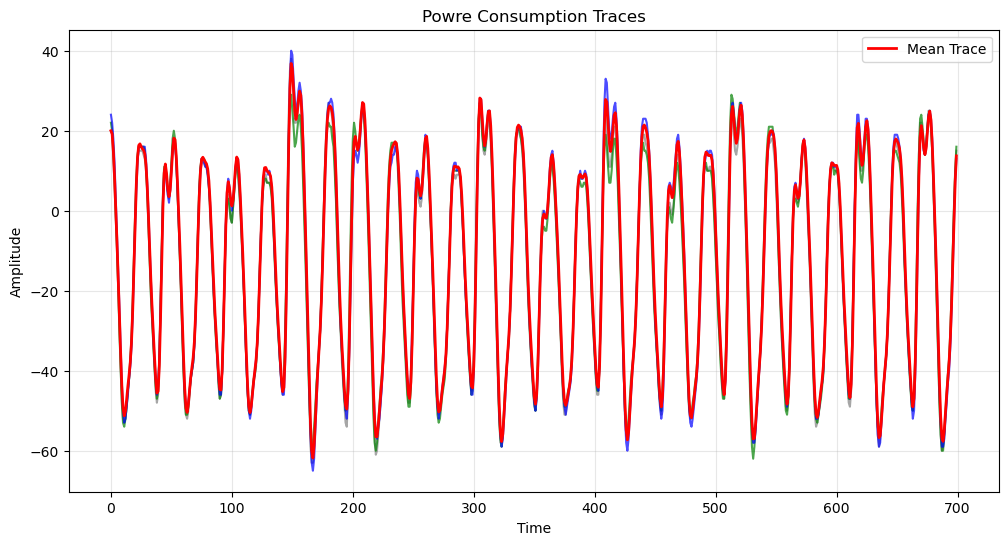

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif


SBOX = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
])

dataset_path = 'data/ASCAD.h5'

with h5py.File(dataset_path, 'r') as f:
    X_train = f['Profiling_traces/traces'][:]
    Labels_train = f['Profiling_traces/metadata'][:]
    X_attack = f['Attack_traces/traces'][:]
    Labels_attack = f['Attack_traces/metadata'][:]

    first_byte_attack_key = Labels_attack['key'][0,:][1]
    second_byte_attack_key = Labels_attack['key'][0,:][2]
    third_byte_attack_key = Labels_attack['key'][0,:][3]
    fourth_byte_attack_key = Labels_attack['key'][0,:][4]

key_byte = 2

print(f"Traning labels: {Labels_train.dtype}")
print(f"Attack labels: {Labels_attack.dtype}")

print(f"Training traces shape: {X_train.shape}")
print(f"Attack traces shape: {X_attack.shape}")

#I do this to get the intermediate sbox value of the AES algorithm
Y_sbox_train = SBOX[Labels_train['plaintext'][:,2] ^ Labels_train['key'][:,key_byte]]  
Y_sbox_attack = SBOX[Labels_attack['plaintext'][:,2] ^ Labels_attack['key'][:,key_byte]]


plt.figure(figsize=(12, 6))
plt.plot(X_train[0], color='grey', alpha=0.7)
plt.plot(X_train[1], color='green', alpha=0.7)
plt.plot(X_train[2], color='blue', alpha=0.7)

plt.plot(np.mean(X_train, axis=0), color='red', linewidth=2, label='Mean Trace')
plt.title("Powre Consumption Traces")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



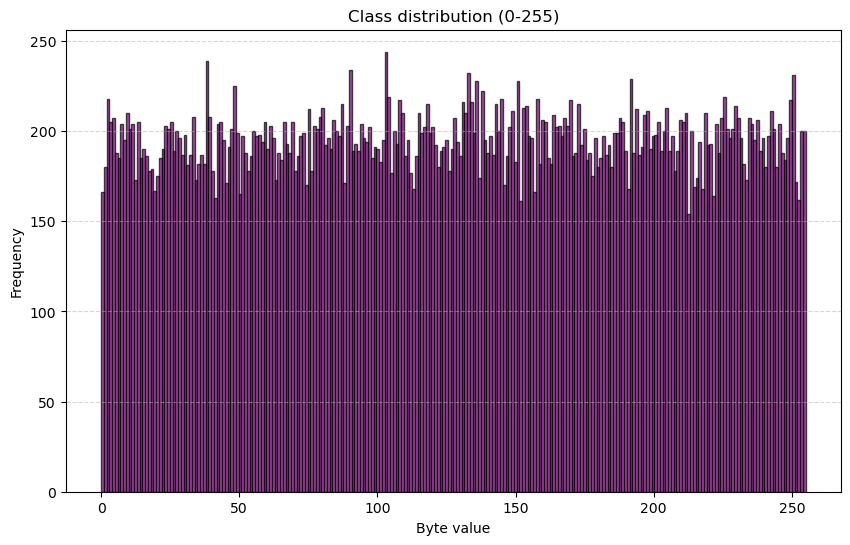

In [3]:
import pandas as pd


s_labels = pd.Series(Y_sbox_train)

plt.figure(figsize=(10, 6))
s_labels.plot.hist(bins=256, color='purple', edgecolor='black', alpha=0.7)
plt.title("Class distribution (0-255)")
plt.xlabel("Byte value")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

In [ ]:
print(f"Check NaN in X_train: {np.isnan(X_train).any()}")
print(f"Check NaN in X_attack: {np.isnan(X_attack).any()}")
print(f"Check NaN in Y_sbox_train: {np.isnan(Y_sbox_train).any()}")
print(f"Check NaN in Y_sbox_attack: {np.isnan(Y_sbox_attack).any()}")
print("\n---------------------------------------\n")
print(f"Check Inf in X_train: {np.isnan(X_train).any()}")
print(f"Check Inf in X_attack: {np.isnan(X_attack).any()}")
print(f"Check Inf in Y_sbox_train: {np.isnan(Y_sbox_train).any()}")
print(f"Check Inf in Y_sbox_attack: {np.isnan(Y_sbox_attack).any()}")

print("\n---------------------------------------\n")
std_dev_train = np.std(X_train, axis=0)
print(f"Check 0 standard deviation {len(np.where(std_dev_train == 0)[0])}")


Check NaN in X_train: False
Check NaN in X_attack: False
Check NaN in Y_sbox_train: False
Check NaN in Y_sbox_attack: False

---------------------------------------

Check Inf in X_train: False
Check Inf in X_attack: False
Check Inf in Y_sbox_train: False
Check Inf in Y_sbox_attack: False

---------------------------------------

Check 0 standard deviation 0


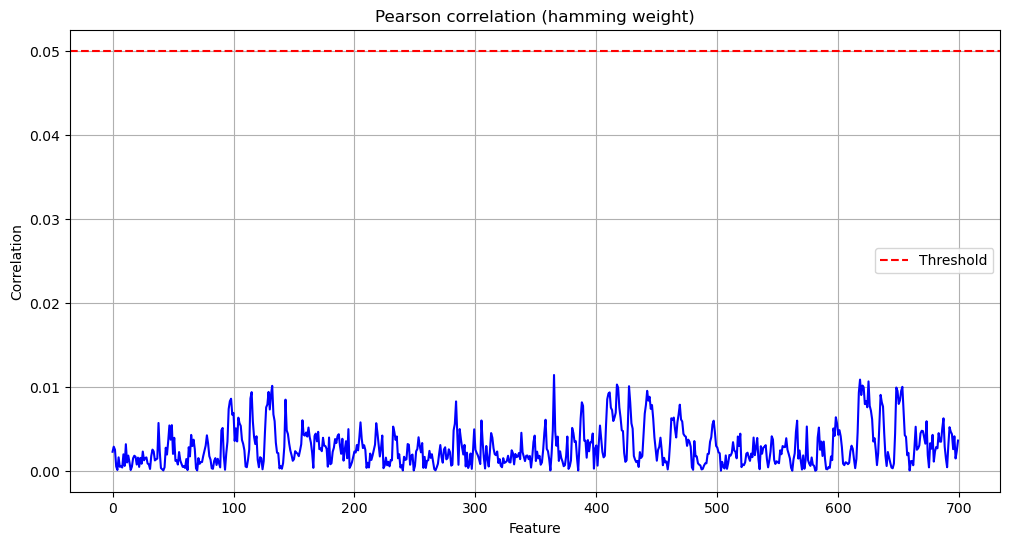

In [5]:
def pearson_correlation(X, y):    
    hamming_table = np.array([bin(x).count("1") for x in range(256)])
    y_hamming_train = hamming_table[y]
    n = len(y_hamming_train)
    y_centered_train = y_hamming_train - np.mean(y_hamming_train)
    x_centered_train = X - np.mean(X, axis=0)
    y_standard_deviation = np.std(y_hamming_train)
    x_standard_deviation = np.std(X, axis=0)
    correlations = np.dot(y_centered_train, x_centered_train) / (n * y_standard_deviation * x_standard_deviation)

    plt.figure(figsize=(12, 6))
    plt.plot(abs(correlations), color='blue')
    plt.title("Pearson correlation (hamming weight)")
    plt.xlabel("Feature")
    plt.ylabel("Correlation")
    plt.axhline(y=0.05, color='r', linestyle='--', label='Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()
pearson_correlation(X_train, Y_sbox_train)


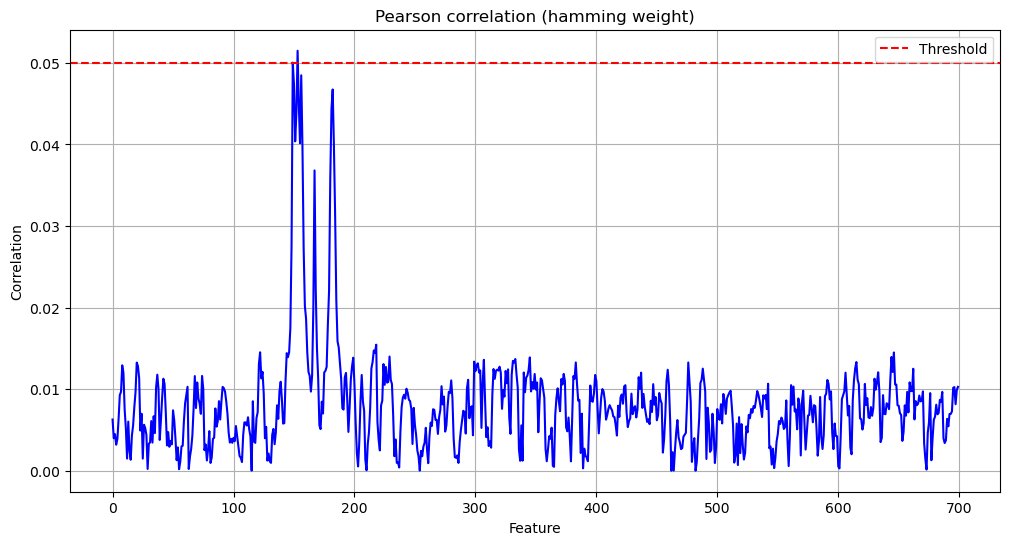

In [6]:
def second_order_preprocessing(X_train, X_attack):
    mean_vec = np.mean(X_train, axis=0)
    X_train_sq = (X_train - mean_vec) ** 2
    X_attack_sq = (X_attack - mean_vec) ** 2
    return X_train_sq, X_attack_sq

X_train_proc, X_attack_proc = second_order_preprocessing(X_train, X_attack)
pearson_correlation(X_train_proc, Y_sbox_train)

<h1>Feature selection</h1>

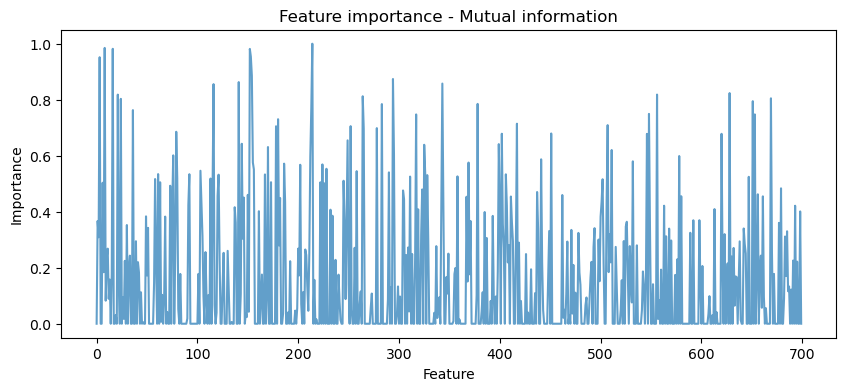

In [7]:
def mutual_information(X, y):
    
    mi_scores = mutual_info_classif(X, y, discrete_features=False, random_state=42, n_jobs=4)    
    plt.figure(figsize=(10, 4))
    plt.plot(mi_scores / mi_scores.max(), alpha=0.7)
    plt.title("Feature importance - Mutual information")
    plt.ylabel("Importance")
    plt.xlabel("Feature")
    plt.show()
    return mi_scores

mi_features = np.argsort(mutual_information(X_train_proc, Y_sbox_train))


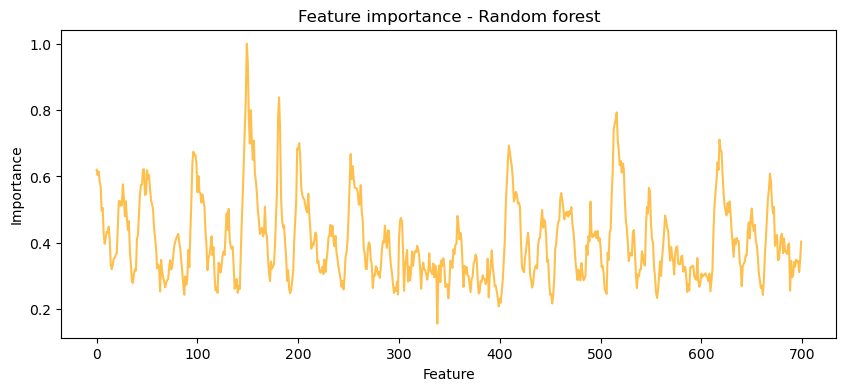

In [8]:
def random_forest(X, y):
    importances = []
    for i in range(10):
        rf = RandomForestClassifier(n_estimators=250, max_depth=10, criterion="entropy", min_samples_leaf=20, min_samples_split=30, n_jobs=4, random_state=i)
        rf.fit(X, y)
        importances.append(rf.feature_importances_)
    imporances_matrix = np.array(importances)
    mean_importances = np.mean(imporances_matrix, axis=0)
    plt.figure(figsize=(10, 4))
    plt.plot(mean_importances / mean_importances.max(),  alpha=0.7, color='orange')
    plt.title("Feature importance - Random forest")
    plt.ylabel("Importance")
    plt.xlabel("Feature")
    plt.show()
    return mean_importances

rf_features = np.argsort(random_forest(X_train_proc, Y_sbox_train))
    

<h1>Models</h1>

In [9]:
def get_number_of_traces_with_threshold(rank, threshold=0.5):
    for i in range(len(rank)):
        if all(rank[i:] <= threshold):
            return i + 1  
    return None

def get_number_of_traces(ranks_array):
    ranks = np.array(ranks_array)
    if ranks[-1] != 0:
        return None
    indices_not_zero = np.where(ranks > 0)[0]
    
    if len(indices_not_zero) == 0:
        return 1 
    
    i = indices_not_zero[-1]
    number_of_traces = (i + 2) 
    
    return number_of_traces

def calculate_rank(model_proba, Y_attack, real_key, byte_target):
    plaintexts = Y_attack['plaintext'][:, byte_target]
    number_of_traces = len(plaintexts)
    
    key_scores = np.zeros(256)
    rank_evolution = []
    epsilon = 1e-40
    
    for i in range(number_of_traces):
        p = plaintexts[i]
        k_guesses = np.arange(256)
        classes = SBOX[p ^ k_guesses]
        
        probabilities = model_proba[i, classes]
        
        key_scores += np.log(probabilities + epsilon)
        
        sorted_indices = np.argsort(key_scores)[::-1] 
        rank = np.where(sorted_indices == real_key)[0][0]
        
        rank_evolution.append(rank)
         
    return rank_evolution

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import top_k_accuracy_score

scaler = StandardScaler()

def random_forest_attack(X_train, X_attack, Y_train, features, random_state):
    X_train_reduced = scaler.fit_transform(X_train[:, features])
    X_attack_reduced = scaler.transform(X_attack[:, features])

    rf_model = RandomForestClassifier(n_estimators=250, criterion="entropy", max_depth=10, n_jobs=4,min_samples_leaf=20, min_samples_split=30, random_state=random_state, class_weight='balanced')
    rf_model.fit(X_train_reduced, Y_train)
    prob_rf = rf_model.predict_proba(X_attack_reduced)
    acc_top1 = top_k_accuracy_score(Y_sbox_attack, prob_rf, k=1)
    acc_top5 = top_k_accuracy_score(Y_sbox_attack, prob_rf, k=5)
    rank_rf = calculate_rank(prob_rf, Labels_attack, second_byte_attack_key, byte_target=key_byte)
    predctions = rf_model.predict(X_attack_reduced)
    return rank_rf, predctions, acc_top1, acc_top5, 

ranks_rf_rf = []
ranks_rf_mi = []
acc_top1_rf_rf = []
acc_top5_rf_rf = []
acc_top1_rf_mi = []
acc_top5_rf_mi = []
last_predictions_rf = None
n_traces_rf_rf = []
n_traces_rf_mi = []

n_folds = 10  
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=123)

for i, (train_index, val_index) in enumerate(skf.split(X_train_proc, Y_sbox_train)):
    X_train_fold = X_train_proc[train_index]
    Y_train_fold = Y_sbox_train[train_index]
    
    rank_rf_rf, preds_rf_rf, acc_top1_rf, acc_top5_rf = random_forest_attack(X_train_fold, X_attack_proc, Y_train_fold, rf_features[-100:], i)
    rank_rf_mi, preds_rf_mi, acc_top1_mi, acc_top5_mi = random_forest_attack(X_train_fold, X_attack_proc,Y_train_fold, mi_features[-100:], i)

    last_predictions_rf_rf = preds_rf_rf
    last_predictions_rf_mi = preds_rf_mi
    ranks_rf_rf.append(rank_rf_rf)
    ranks_rf_mi.append(rank_rf_mi)
    acc_top1_rf_rf.append(acc_top1_rf)
    acc_top5_rf_rf.append(acc_top5_rf)
    acc_top1_rf_mi.append(acc_top1_mi)
    acc_top5_rf_mi.append(acc_top5_mi)

rf_rf_matrix = np.array(ranks_rf_rf)
rf_mi_matrix = np.array(ranks_rf_mi)

rf_rf_mean = np.mean(rf_rf_matrix,axis=0)
rf_mi_mean = np.mean(rf_mi_matrix,axis=0)

n_traces_rank_0_rf_rf = get_number_of_traces_with_threshold(rf_rf_mean)
n_traces_rank_0_rf_mi = get_number_of_traces_with_threshold(rf_mi_mean)

In [11]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

def gaussian_nb_attack(X_train, X_attack, features):
    X_train_reduced = X_train[:, features]
    X_attack_reduced = X_attack[:, features]
    model_pca_gnb = make_pipeline(
        StandardScaler(),
        PCA(n_components=20, whiten=True, random_state=123),
        GaussianNB()
    )
    model_pca_gnb.fit(X_train_reduced, Y_train_fold)
    prob_gnb = model_pca_gnb.predict_proba(X_attack_reduced)
    acc_top1 = top_k_accuracy_score(Y_sbox_attack, prob_gnb, k=1)
    acc_top5 = top_k_accuracy_score(Y_sbox_attack, prob_gnb, k=5)
    rank_gnb = calculate_rank(prob_gnb, Labels_attack, second_byte_attack_key, byte_target=key_byte)
    preds = model_pca_gnb.predict(X_attack_reduced)
    return rank_gnb, acc_top1, acc_top5, preds

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=123)
ranks_gnb_rf = []
ranks_gnb_mi = []
acc_top1_gnb_rf = []
acc_top5_gnb_rf = []
acc_top1_gnb_mi = []
acc_top5_gnb_mi = []


for i, (train_index, val_index) in enumerate(skf.split(X_train_proc, Y_sbox_train)):
    X_train_fold = X_train_proc[train_index]
    Y_train_fold = Y_sbox_train[train_index]

    rank_gnb_rf, acc_top1_rf, acc_top5_rf, preds_gnb_rf = gaussian_nb_attack(X_train_fold, X_attack_proc, rf_features[-20:])
    rank_gnb_mi, acc_top1_mi, acc_top5_mi, preds_gnb_mi = gaussian_nb_attack(X_train_fold, X_attack_proc, mi_features[-20:])
    last_predictions_gnb_rf = preds_gnb_rf
    last_predictions_gnb_mi = preds_gnb_mi
    ranks_gnb_rf.append(rank_gnb_rf)
    ranks_gnb_mi.append(rank_gnb_mi)
    acc_top1_gnb_rf.append(acc_top1_rf)
    acc_top5_gnb_rf.append(acc_top5_rf)
    acc_top1_gnb_mi.append(acc_top1_mi)
    acc_top5_gnb_mi.append(acc_top5_mi)

gnb_rf_matrix = np.array(ranks_gnb_rf)
gnb_mi_matrix = np.array(ranks_gnb_mi)

gnb_rf_mean = np.mean(np.array(gnb_rf_matrix), axis=0)
gnb_mi_mean = np.mean(np.array(gnb_mi_matrix), axis=0)

n_traces_rank_0_gnb_rf = get_number_of_traces_with_threshold(gnb_rf_mean)
n_traces_rank_0_gnb_mi = get_number_of_traces_with_threshold(gnb_mi_mean)

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def mlp_attack(X, X_a, Y, random_state=123):
    def keras_mlp(meta, **kwargs):
        n_features_in_ = meta["n_features_in_"]
    
        model = Sequential([
            Input(shape=(n_features_in_,)),
            Dense(400, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            Dense(400, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            Dense(256, activation='softmax')
        ])
    
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model  


    mlp = KerasClassifier(
        model=keras_mlp,
        epochs=10,               
        batch_size=64,           
        random_state=random_state,
        verbose=0
    )

    mlp_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', mlp)
    ])

    y_train_cat = to_categorical(Y, num_classes=256)
    mlp_pipeline.fit(X, y_train_cat)

    prob_mlp = mlp_pipeline.predict_proba(X_a)

    acc_top1 = top_k_accuracy_score(Y_sbox_attack, prob_mlp, k=1)
    acc_top5 = top_k_accuracy_score(Y_sbox_attack, prob_mlp, k=5)
    rank_mlp = calculate_rank(prob_mlp, Labels_attack, Labels_train['key'][0,2], byte_target=2)
    pred = np.argmax(prob_mlp, axis=1)

    return rank_mlp, acc_top1, acc_top5, pred

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=123)
ranks_mlp = []
acc_top1_mlp = []
acc_top5_mlp = []

for i, (train_index, val_index) in enumerate(skf.split(X_train, Y_sbox_train)):
    X_train_fold = X_train[train_index]
    Y_train_fold = Y_sbox_train[train_index]

    rank_mlp, acc_top1, acc_top5, preds_mlp = mlp_attack(X_train_fold, X_attack, Y_train_fold, random_state=i)
    last_predictions_mlp = preds_mlp
    ranks_mlp.append(rank_mlp)
    acc_top1_mlp.append(acc_top1)
    acc_top5_mlp.append(acc_top5)

mlp_matrix = np.array(ranks_mlp)
mlp_mean = np.mean(mlp_matrix, axis=0)


n_traces_rank_0_mlp = get_number_of_traces_with_threshold(mlp_mean)

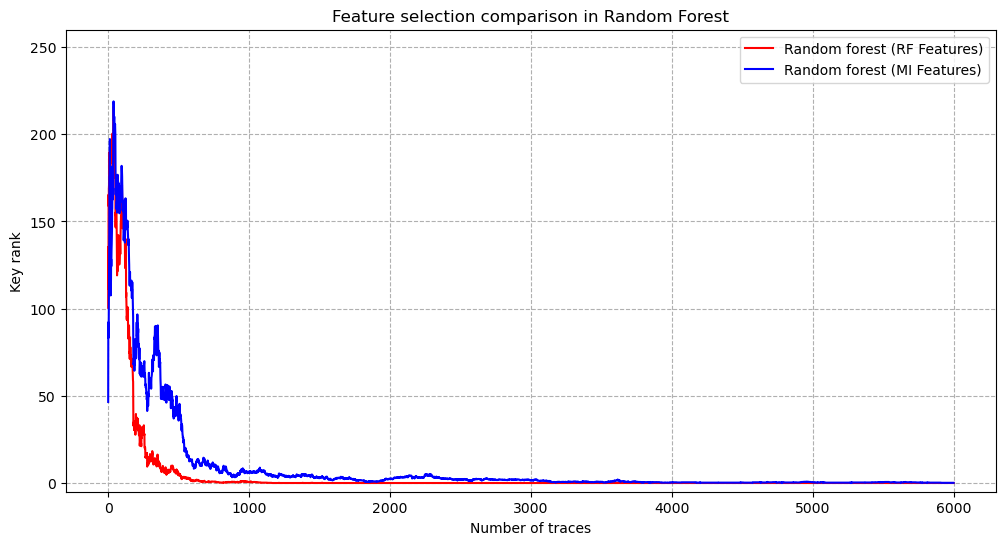

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(rf_rf_mean[:6000], label='Random forest (RF Features)', color='red')
plt.plot(rf_mi_mean[:6000], label='Random forest (MI Features)', color='blue')
plt.title(f'Feature selection comparison in Random Forest')
plt.xlabel('Number of traces')
plt.ylabel('Key rank')
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.ylim(bottom=-5, top=260)
plt.show()

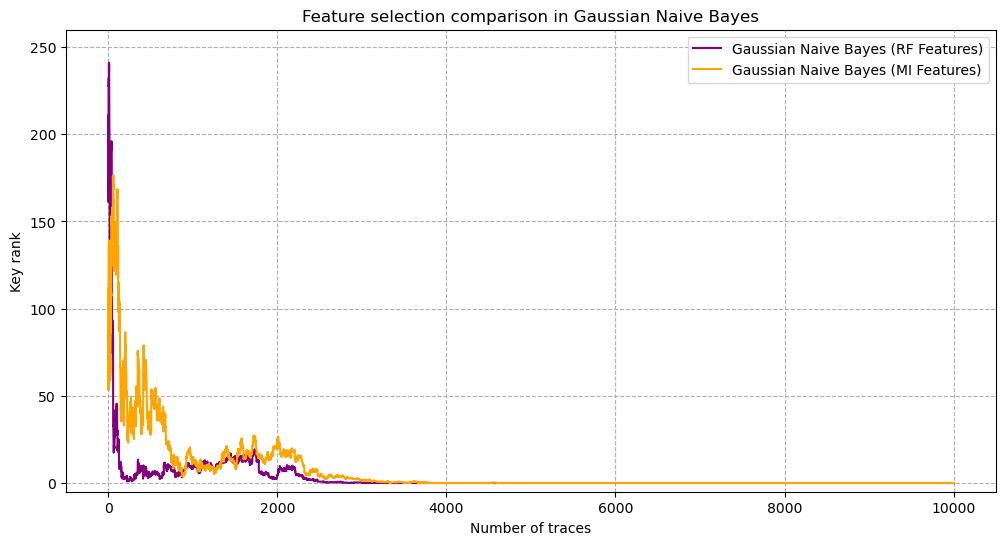

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(gnb_rf_mean, label='Gaussian Naive Bayes (RF Features)', color='purple')
plt.plot(gnb_mi_mean, label='Gaussian Naive Bayes (MI Features)', color='orange')
plt.title(f'Feature selection comparison in Gaussian Naive Bayes')
plt.xlabel('Number of traces')
plt.ylabel('Key rank')
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.ylim(bottom=-5, top=260)
plt.show()

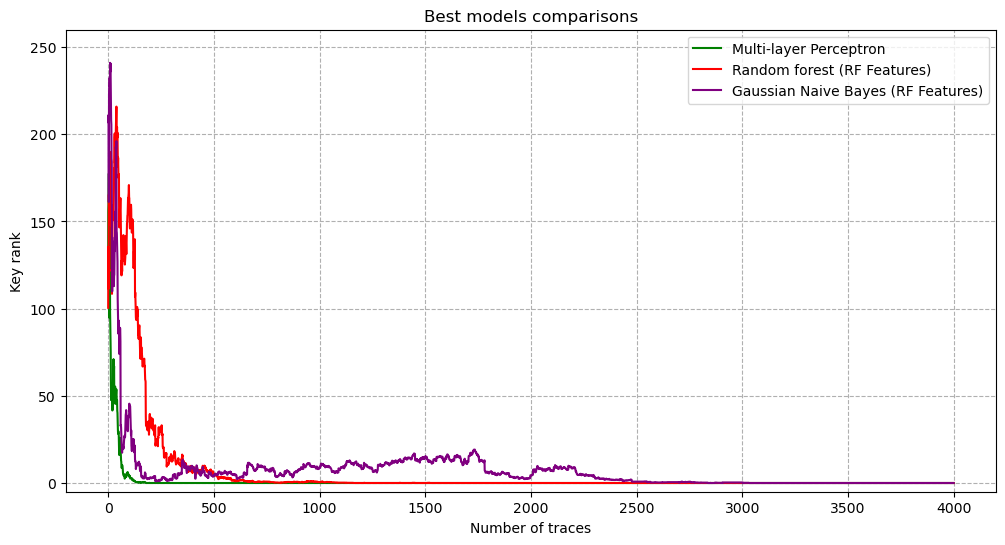

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(mlp_mean[:4000], label='Multi-layer Perceptron', color='green')
plt.plot(rf_rf_mean[:4000], label='Random forest (RF Features)', color='red')
plt.plot(gnb_rf_mean[:4000], label='Gaussian Naive Bayes (RF Features)', color='purple')
plt.title(f'Best models comparisons')
plt.xlabel('Number of traces')
plt.ylabel('Key rank')
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.ylim(bottom=-5, top=260)
plt.show()

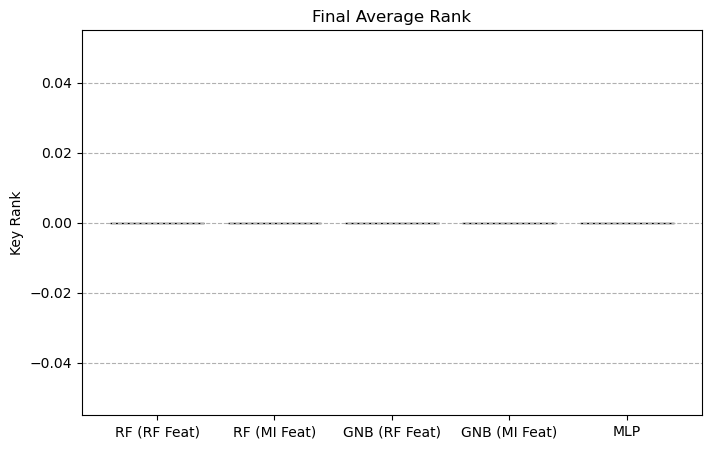

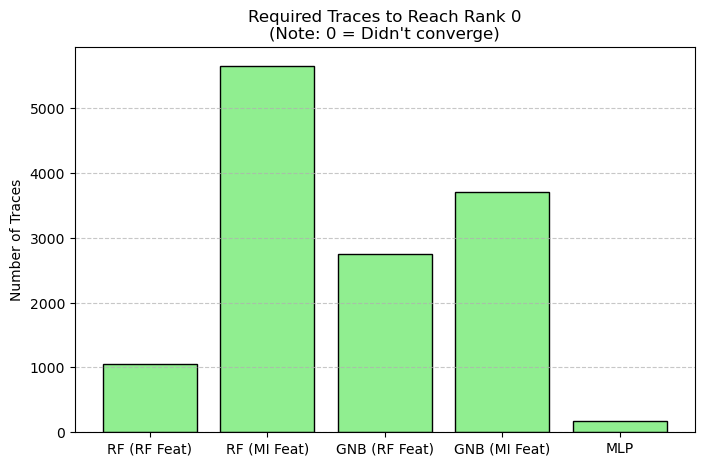

In [16]:
import matplotlib.pyplot as plt

models = ['RF (RF Feat)', 'RF (MI Feat)', 'GNB (RF Feat)', 'GNB (MI Feat)', 'MLP']

ranks = [rank_rf_rf[-1], rank_rf_mi[-1], rank_gnb_rf[-1], rank_gnb_mi[-1], rank_mlp[-1]]
traces_raw = [n_traces_rank_0_rf_rf, n_traces_rank_0_rf_mi, n_traces_rank_0_gnb_rf, n_traces_rank_0_gnb_mi, n_traces_rank_0_mlp]
traces_clean = [t if t is not None else 0 for t in traces_raw]

plt.figure(figsize=(8, 5))
plt.bar(models, ranks, color='skyblue', edgecolor='black')

plt.title('Final Average Rank')
plt.ylabel('Key Rank')
plt.grid(axis='y', linestyle='--')

plt.show()

plt.figure(figsize=(8, 5))
plt.bar(models, traces_clean, color='lightgreen', edgecolor='black')

plt.title('Required Traces to Reach Rank 0\n(Note: 0 = Didn\'t converge)')
plt.ylabel('Number of Traces')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

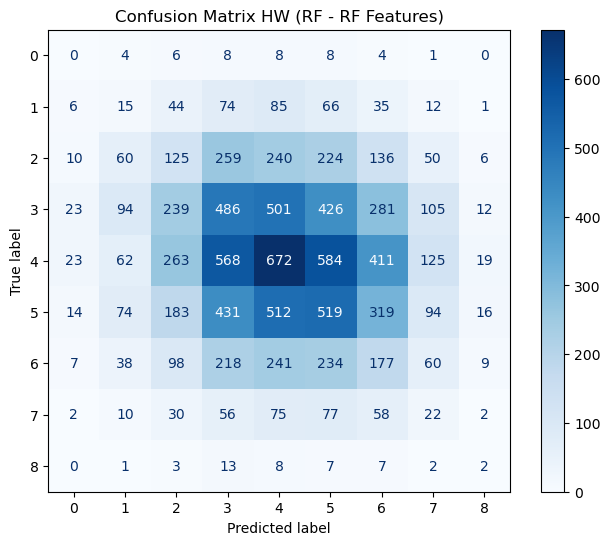

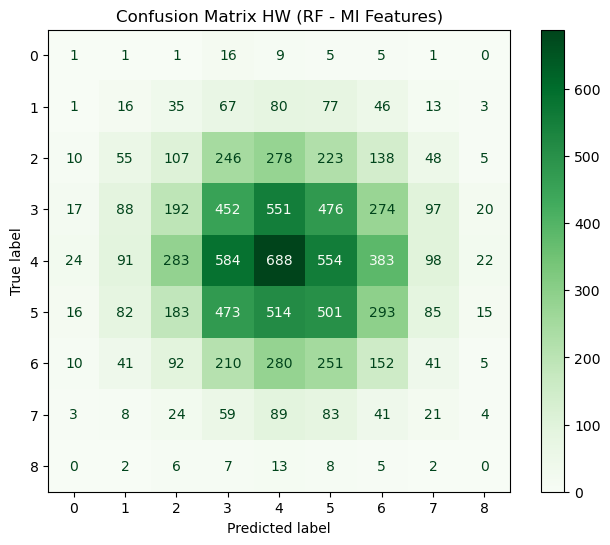

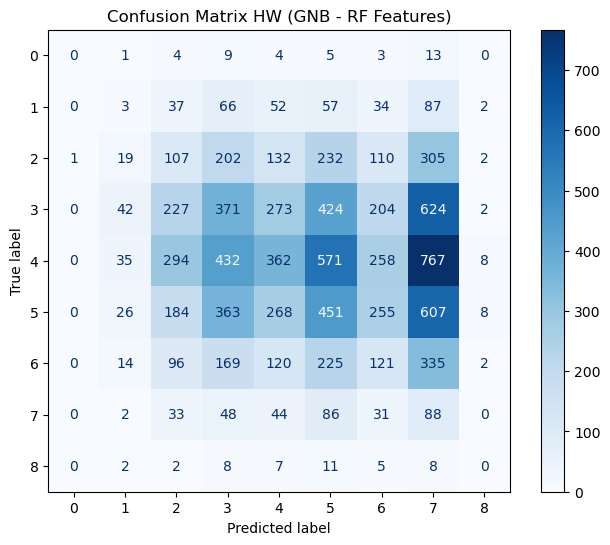

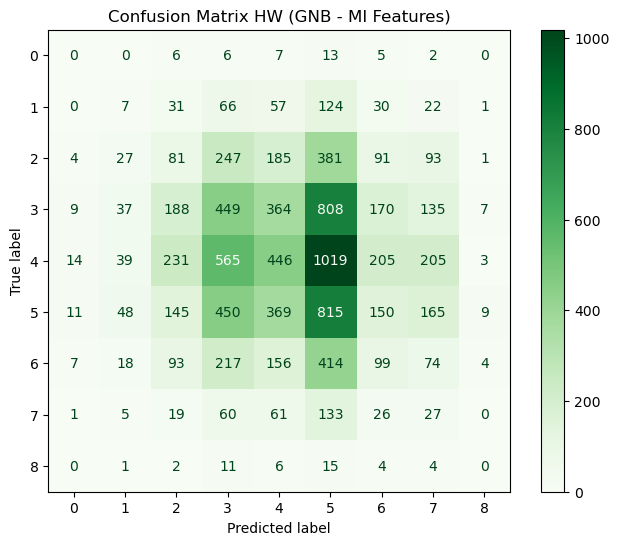

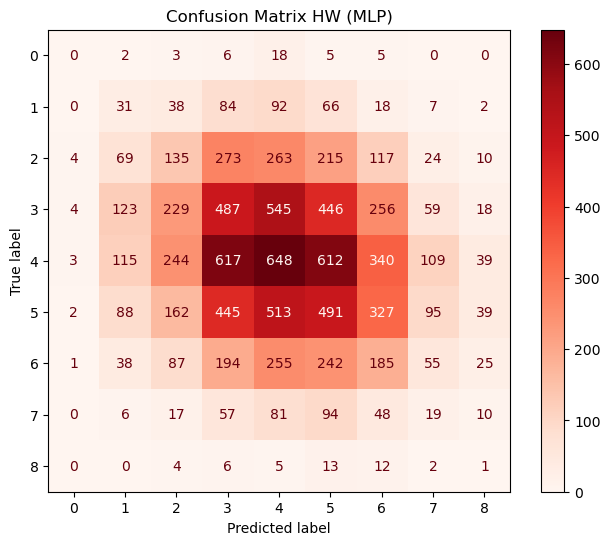

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true_hw = [bin(int(x)).count('1') for x in Y_sbox_attack]

y_pred_hw_rf_rf = [bin(int(x)).count('1') for x in last_predictions_rf_rf]
y_pred_hw_rf_mi = [bin(int(x)).count('1') for x in last_predictions_rf_mi]
y_pred_hw_gnb_rf = [bin(int(x)).count('1') for x in last_predictions_gnb_rf]
y_pred_hw_gnb_mi = [bin(int(x)).count('1') for x in last_predictions_gnb_mi]
y_pred_hw_mlp = [bin(int(x)).count('1') for x in last_predictions_mlp]

plt.figure(figsize=(8, 6))
cm_rf_rf_hw = confusion_matrix(y_true_hw, y_pred_hw_rf_rf, labels=range(9))
ConfusionMatrixDisplay(cm_rf_rf_hw).plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title("Confusion Matrix HW (RF - RF Features)")
plt.show()

plt.figure(figsize=(8, 6))
cm_rf_mi_hw = confusion_matrix(y_true_hw, y_pred_hw_rf_mi, labels=range(9))
ConfusionMatrixDisplay(cm_rf_mi_hw).plot(cmap='Greens', values_format='d', ax=plt.gca())
plt.title("Confusion Matrix HW (RF - MI Features)")
plt.show()

plt.figure(figsize=(8, 6))
cm_gnb_rf_hw = confusion_matrix(y_true_hw, y_pred_hw_gnb_rf, labels=range(9))
ConfusionMatrixDisplay(cm_gnb_rf_hw).plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title("Confusion Matrix HW (GNB - RF Features)")
plt.show()

plt.figure(figsize=(8, 6))
cm_gnb_mi_hw = confusion_matrix(y_true_hw, y_pred_hw_gnb_mi, labels=range(9))
ConfusionMatrixDisplay(cm_gnb_mi_hw).plot(cmap='Greens', values_format='d', ax=plt.gca())
plt.title("Confusion Matrix HW (GNB - MI Features)")
plt.show()

plt.figure(figsize=(8, 6))
cm_mlp_hw = confusion_matrix(y_true_hw, y_pred_hw_mlp, labels=range(9))
ConfusionMatrixDisplay(cm_mlp_hw).plot(cmap='Reds', values_format='d', ax=plt.gca())
plt.title("Confusion Matrix HW (MLP)")
plt.show()

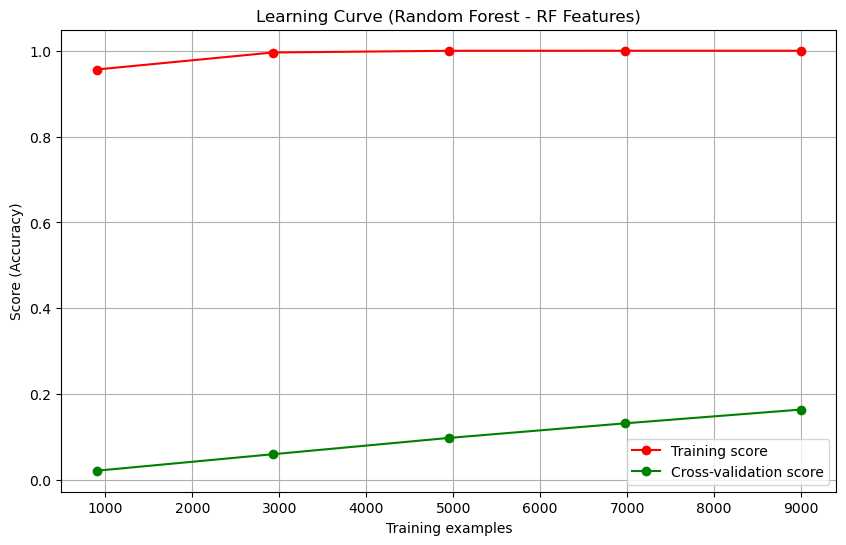

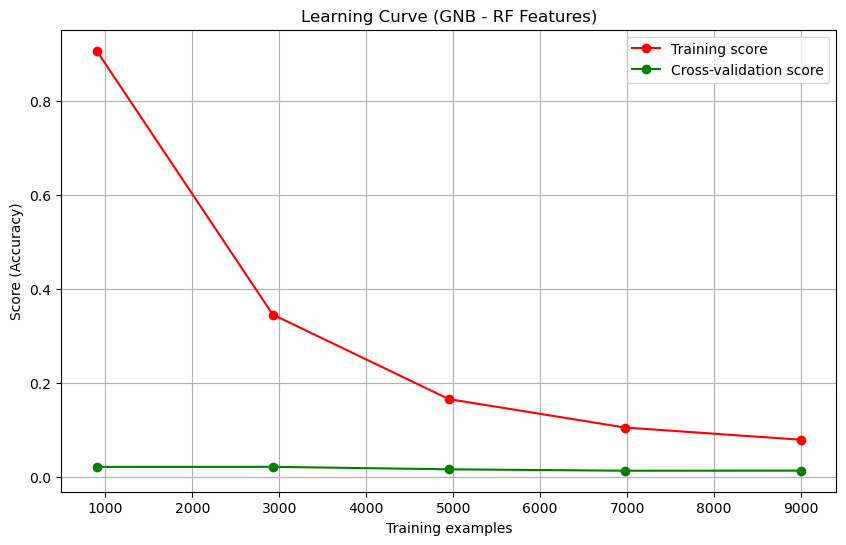

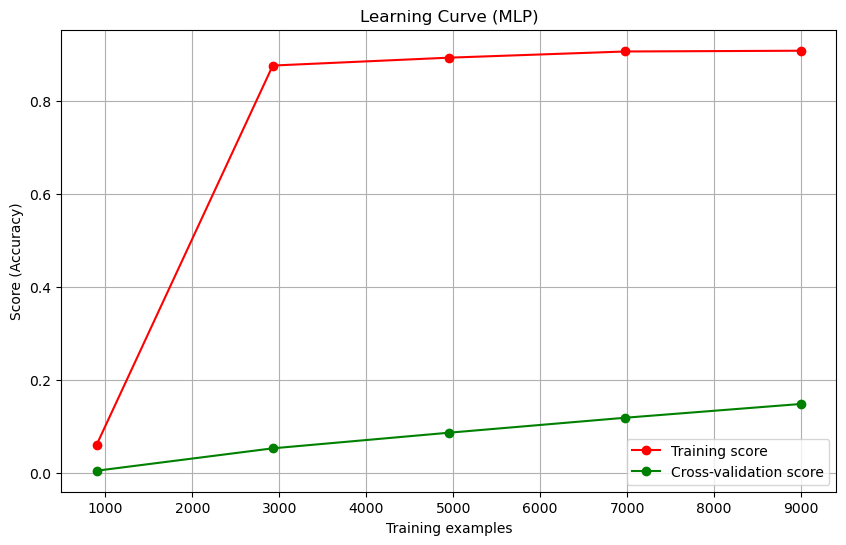

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample


def plot_learning_curve(estimator, title, X, y, cv=5, n_jobs=4):    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, 
        X, 
        y, 
        cv=cv, 
        n_jobs=n_jobs, 
        train_sizes=np.linspace(0.1, 1.0, 5), 
        scoring='accuracy' 
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score (Accuracy)")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="red", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="green", label="Cross-validation score")

    plt.legend(loc="best")
    plt.grid(True)
    plt.show()


X_sub, Y_sub = resample(X_train_proc[:, rf_features], Y_sbox_train, n_samples=10000, random_state=123)

rf_model = RandomForestClassifier(n_estimators=250, criterion="entropy", max_depth=10, n_jobs=4,min_samples_leaf=20, min_samples_split=30, random_state=123, class_weight='balanced')
gnb_model = GaussianNB()
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(256, 256, 256), activation='relu', 
                          solver='adam', alpha=0.001, batch_size=256, 
                          max_iter=300, early_stopping=True, random_state=123))
])

plot_learning_curve(rf_model, "Learning Curve (Random Forest - RF Features)", 
                    X_sub[:, rf_features], 
                    Y_sub, 
                    cv=10, n_jobs=4)

plot_learning_curve(gnb_model, "Learning Curve (GNB - RF Features)", 
                    X_sub[:, rf_features], 
                    Y_sub, 
                    cv=10, n_jobs=4)

plot_learning_curve(mlp_pipeline, "Learning Curve (MLP)", 
                    X_sub, 
                    Y_sub, 
                    cv=10, n_jobs=4)

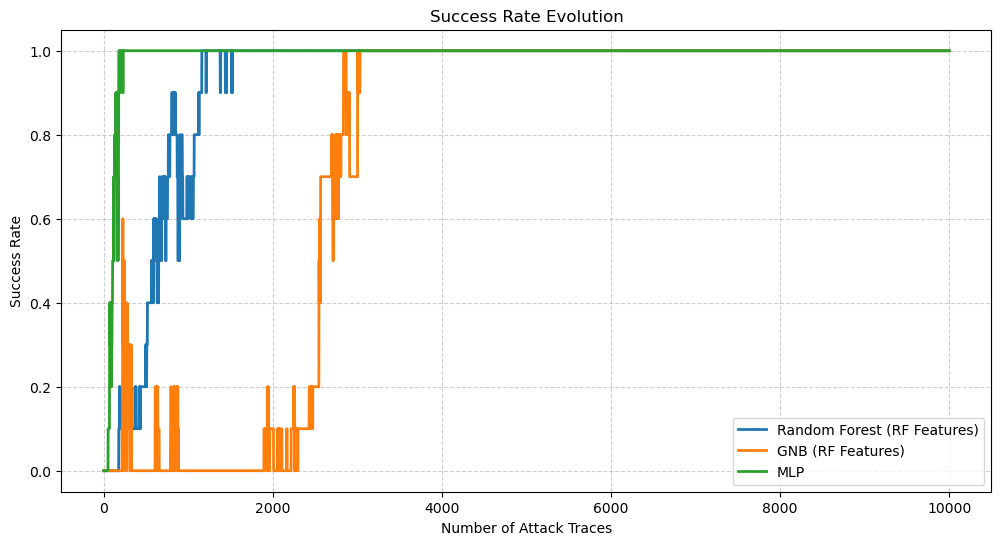

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def get_success_rate(ranks_matrix):
    return np.mean(np.array(ranks_matrix) == 0, axis=0)

plt.figure(figsize=(12, 6))

sr_rf_rf = get_success_rate(rf_rf_matrix)
sr_rf_mi = get_success_rate(rf_mi_matrix)
sr_gnb_rf = get_success_rate(gnb_rf_matrix)
sr_gnb_mi = get_success_rate(gnb_mi_matrix)
sr_mlp = get_success_rate(mlp_matrix)

plt.plot(sr_rf_rf, label='Random Forest (RF Features)', linewidth=2)
plt.plot(sr_gnb_rf, label='GNB (RF Features)', linewidth=2)
plt.plot(sr_mlp, label='MLP', linewidth=2)

plt.title("Success Rate Evolution")
plt.xlabel("Number of Attack Traces")
plt.ylabel("Success Rate")
plt.ylim(-0.05, 1.05)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.show()

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

models = ['RF (RF features)', 'GNB (RF features)', 'GNB (MI features)', 'RF (MI features)', 'MLP']

top1 = [
    np.mean(acc_top1_rf_rf) * 100, 
    np.mean(acc_top1_gnb_rf) * 100, 
    np.mean(acc_top1_gnb_mi) * 100, 
    np.mean(acc_top1_rf_mi) * 100, 
    np.mean(acc_top1_mlp) * 100
]

top5 = [
    np.mean(acc_top5_rf_rf) * 100, 
    np.mean(acc_top5_gnb_rf) * 100, 
    np.mean(acc_top5_gnb_mi) * 100, 
    np.mean(acc_top5_rf_mi) * 100, 
    np.mean(acc_top5_mlp) * 100
]

df = pd.DataFrame({
    'Model': models,
    'Top-1 Acc (%)': top1,
    'Top-5 Acc (%)': top5
})

print("Accuracy:\n\n")

print(df.round(2).to_string(index=False)) 


Accuracy:


            Model  Top-1 Acc (%)  Top-5 Acc (%)
 RF (RF features)           0.40           2.17
GNB (RF features)           0.41           2.11
GNB (MI features)           0.46           2.11
 RF (MI features)           0.45           2.14
              MLP           0.71           3.40
